## HeartBD2K Data Science Internship Fall 2017
### Priyanka Nanayakkara

The goal of the following project is to analyze time expressions (for example: "2 years later," "daily") in case reports on PubMed. To extract time expressions from the text, I used SUTime (http://nlp.stanford.edu:8080/sutime/process) and a Python wrapper for SUTime (https://github.com/FraBle/python-sutime).

SUTime returns annotations as JSON objects. The following reads in the annotations and adds them to a dataframe.

In [53]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from statistics import mean,median

############### Importing data ######################
# Case Reports part A
with open('./time_expressions_part_a.txt', encoding = 'utf-8') as json_file:
    data = json.load(json_file)

ann1 = data['annotations']

df = pd.DataFrame()

for i in range(0,100):
    temp = pd.read_json(ann1[i])
    temp['case_report'] = [i] * len(temp)
    df = df.append(temp)

# Case Reports part B
with open('./time_expressions_part_b.txt', encoding = 'utf-8') as json_file:
    data2 = json.load(json_file)

ann2 = data2['annotations']

df2 = pd.DataFrame()

for i in range(0,100):
    temp = pd.read_json(ann2[i])
    CR = i + 100
    temp['case_report'] = [CR] * len(temp)
    df2 = df2.append(temp)

ann = df.append(df2)



There were 1732 time phrases picked up by SUTime in 200 case reports.

In [54]:
############### Exploring ###############################

# How many annotations?
len(ann)

1732

The mean number of time phrases per case report was 8.66, while the median was 7.

In [55]:
cr_counts=Counter(ann['case_report'])

mean(cr_counts.values())

8.66

In [56]:
median(cr_counts.values())

7.0

To get a better sense of the distribution of phrases per case report, see the histogram below.
The distribution is skewed right.

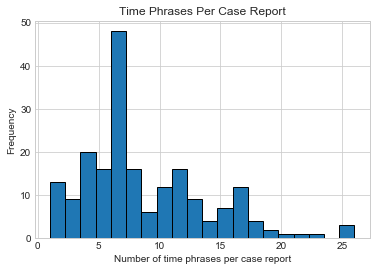

In [66]:
# histogram of time phrases per case report
plt.hist(cr_counts.values(),bins=20,histtype='bar',ec='black')
plt.xlabel('Number of time phrases per case report')
plt.ylabel('Frequency')
plt.title('Time Phrases Per Case Report')
plt.show()

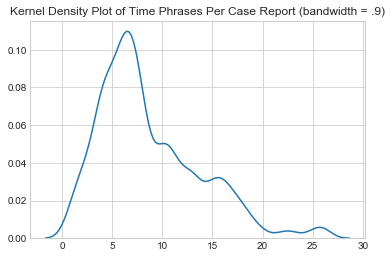

In [68]:
sns.set_style('whitegrid')
sns.kdeplot(list(cr_counts.values()), bw=0.9)
plt.title('Kernel Density Plot of Time Phrases Per Case Report (bandwidth = .9)')
plt.show()

SUTime labels time phrases with one of four values: DATE, DURATION, SET, TIME.
<br>
<br>
An example of each from this data are as follows:
<br>
<br>
-DATE: March 2011
<br>
-DURATION: 12 months 
<br>
-SET: daily 
<br>
-TIME: one in the evening

The number of each category of time phrase is below.

In [59]:
types=Counter(ann['type'])
types

Counter({'DATE': 526, 'DURATION': 1035, 'SET': 133, 'TIME': 38})

DURATION is clearly the most common type of annotation in this dataset.

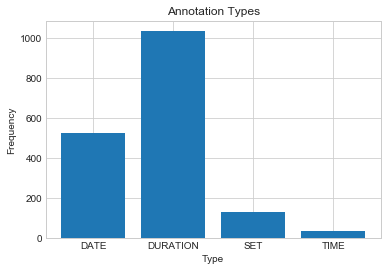

In [60]:
plt.bar(types.keys(),types.values())
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.title('Annotation Types')
plt.show()

However, some DURATIONs picked up by SUTime don't make sense in this context. For example, SUTime marked ages as DURATIONs (ie, 34-year-old). Once removing these false durations, the duration count goes down.

In [61]:
ann['type_new'] = ann['type']
for i in range(0,len(ann)):
    if re.findall(r'\d{,3}-year-old',ann['text'][i]) != []:
        ann.loc[i,'type_new'] = 'FALSE_DURATION'
    elif re.findall(r'\d{,3}-yr-old',ann['text'][i]) != []:
        ann.loc[i,'type_new'] = 'FALSE_DURATION'

# fix false dates that are actually just integers
for i in range(0,len(ann)):
    if re.findall(r'^\d+$',ann['text'][i]) != []:
        ann.loc[i,'type_new'] = 'FALSE_DATE'

types_new=Counter(ann['type_new'])
types_new

Counter({'DATE': 455,
         'DURATION': 866,
         'FALSE_DATE': 69,
         'FALSE_DURATION': 171,
         'SET': 133,
         'TIME': 38})

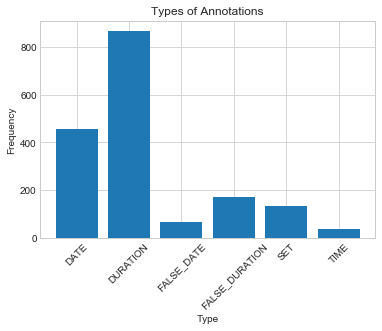

In [62]:
plt.bar(types_new.keys(),types_new.values())
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.xlabel('Type')
plt.title('Types of Annotations')
plt.show()

Distribution of types of phrases per case report are shown below. Distributions for TIME, SET, and DATE are similar, while DURATION's distribution reflects that of the total. This makes sense because DURATION represents a majority of the total annotations. 

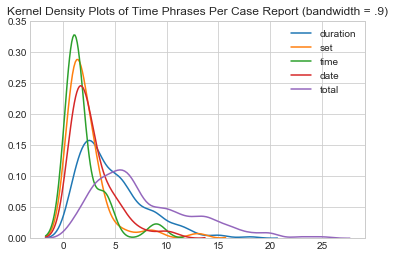

In [63]:
# subset data based on type of time phrase
ann_duration = ann.loc[(ann.type_new == 'DURATION'), ['text','type_new','case_report']]
ann_date = ann.loc[(ann.type_new == 'DATE'), ['text','type_new','case_report']]
ann_set = ann.loc[(ann.type_new == 'SET'), ['text','type_new','case_report']]
ann_time = ann.loc[(ann.type_new == 'TIME'), ['text','type_new','case_report']]
ann_total = ann.loc[(ann.type_new == 'TIME')|(ann.type_new == 'DURATION')|(ann.type_new=='SET')|(ann.type_new=='DATE'), ['text','type_new','case_report']]

# case report counts
cr_duration_counts=Counter(ann_duration['case_report'])
cr_date_counts=Counter(ann_date['case_report'])
cr_set_counts=Counter(ann_set['case_report'])
cr_time_counts=Counter(ann_time['case_report'])
cr_ann_total_counts=Counter(ann_total['case_report'])

# plot
sns.set_style('whitegrid')
sns.kdeplot(list(cr_duration_counts.values()), bw=0.9, label = 'duration')
sns.kdeplot(list(cr_set_counts.values()), bw=0.9,label  = 'set')
sns.kdeplot(list(cr_time_counts.values()), bw=0.9, label = 'time')
sns.kdeplot(list(cr_date_counts.values()), bw=0.9, label = 'date')
sns.kdeplot(list(cr_ann_total_counts.values()),bw=.9,label='total')
plt.title('Kernel Density Plots of Time Phrases Per Case Report (bandwidth = .9)')
plt.legend()
plt.ylim(0,.35)
plt.show()

## Looking Ahead
Moving forward, I plan on using SUTime to collect annotations, and improving the labeling system to be more suited to biomedical literature. (For example, the improved labeling system should not mark ages as durations.) Ultimately, the goal is to create a timeline of events for each case report which shows when medical events occurred in relation to one another. This way, each case report can be the basis of an interactive timeline where users can quickly scroll through a patient's journey with a given condition. The distillation of case reports into event-based timelines can also be used to aggregate information about any given condition quickly to find trends in events (for instance, how much time on average to people take to recover from a certain procedure?).